In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [122]:
source_image_array= []
target_image_array= []
source_image_landmarks= []
target_image_landmarks= []

def read_csv_file():


    DATASET_MEDIUM_DIR = 'dataset_medium.csv'
    Image.MAX_IMAGE_PIXELS = None
    
    
    imgs_dirs = []
    dataset_read_result = pd.read_csv(DATASET_MEDIUM_DIR)
    i = 0
    for each_img_dir, \
        each_landmarks_dir, \
        each_target_image, \
        each_target_landmarks, \
        each_status in zip(dataset_read_result['Source image'],
                           dataset_read_result['Source landmarks'],
                           dataset_read_result['Target image'],
                           dataset_read_result['Target landmarks'],
                           dataset_read_result['status']):
        if each_status=='training':
            each_img_dir = 'image/dataset_medium/' + each_img_dir
            each_landmarks_dir = 'landmark/' + each_landmarks_dir
            each_target_image = 'image/dataset_medium/' + each_target_image
            each_target_landmarks = 'landmark/' + each_target_landmarks

            dataset_read_result.set_value(index=i, col='Source image', value=each_img_dir)
            dataset_read_result.set_value(index=i, col='Source landmarks', value=each_landmarks_dir)
            dataset_read_result.set_value(index=i, col='Target image', value=each_target_image)
            dataset_read_result.set_value(index=i, col='Target landmarks', value=each_target_landmarks)
            
            ######################################
            source_image_array.append(each_img_dir)
            target_image_array.append(each_target_image)
            source_image_landmarks.append(each_landmarks_dir)
            target_image_landmarks.append(each_target_landmarks)
            ##########################
            imgs_dirs.append(each_img_dir)
            i = i + 1

    print(dataset_read_result['Source image'][1])
    print(imgs_dirs[1])
    return dataset_read_result


dataset_read_result = read_csv_file()

# the first 10
# source_image_array = dataset_read_result['Source image']
# target_image_array = dataset_read_result['Target image']
# source_image_landmarks = dataset_read_result['Source landmarks']
# target_image_landmarks = dataset_read_result['Target landmarks']

D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
D:\anaconda\anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


image/dataset_medium/COAD_01/scale-25pc/S6.jpg
image/dataset_medium/COAD_01/scale-25pc/S6.jpg


In [79]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class matchNet(nn.Module):
    def __init__(self):
        #使用super()方法调用基类的构造器，即nn.Module.__init__(self)
        super(matchNet,self).__init__()
        
        
        ## note here wantna to combined two image together
        self.conv_0 = nn.Conv2d(3, 32, kernel_size=2)
        self.pool_0 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_1 = nn.Conv2d(32, 64, kernel_size=2)
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv_2 = nn.Conv2d(64, 128, kernel_size=2, stride=1)
#         self.conv_3 = nn.Conv2d(128, 128, kernel_size=2, stride=1)
#         self.conv_4 = nn.Conv2d(128, 64, kernel_size=2, stride=1)
        self.pool_4 = torch.nn.MaxPool2d(kernel_size=2, stride=1)
        
        
        # input based on previous , output choose from 128, 256, 512
        self.bottleNeck = torch.nn.Linear(128, 512)
        
        # FC layers, input based on the previous, output choose from 128, 256, 512, 1024
        # this layer with the softmax
        self.fc_1 = torch.nn.Linear(1024, 256)
        self.fc_2 = torch.nn.Linear(256, 128)
        self.fc_3 = torch.nn.Linear(128, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        
    def forward(self,x,y):
        
        
        ########################
        x = F.relu(self.conv_0(x))
        x = self.pool_0(x) 
        x = F.relu(self.conv_1(x))
        x = self.pool_1(x) 
        x = F.relu(self.conv_2(x))
#         x = F.relu(self.conv_3(x))
#         x = F.relu(self.conv_4(x))
        x = self.pool_4(x)
        
        x = x.view(-1, 128)
        x = F.relu(self.bottleNeck(x))
        ########################
        
        y = F.relu(self.conv_0(y))
        y = self.pool_0(y) 
        y = F.relu(self.conv_1(y))
        y = self.pool_1(y) 
        y = F.relu(self.conv_2(y))
#         y = F.relu(self.conv_3(y))
#         y = F.relu(self.conv_4(y))
        y = self.pool_4(y)
        
        y = y.view(-1, 128)
        y = F.relu(self.bottleNeck(y))
        #########################
        
        output =torch.cat((x, y),1)
        
        output =self.dropout(F.relu(self.fc_1(output))) 
            
        output = self.dropout(F.relu(self.fc_2(output)))
        output = self.sigmoid(self.fc_3(output))
        
       
        return output

# First using the SIFT to get the point

In [35]:
import cv2
import numpy as np
print(cv2.__version__)

3.3.1


In [36]:
sift = cv2.xfeatures2d.SIFT_create()

imgname1 = source_image_array[1]
imgname2 = target_image_array[1]

In [37]:
scaling_ratio = 50

img1 = cv2.imread(imgname1)
height1, width1, channels = img1.shape
img2 = cv2.imread(imgname2)
height2, width2, channels = img2.shape

height1_resize = int(height1/scaling_ratio)
width1_resize = int(width1/scaling_ratio)

# print(height1) # 16308
# print(height1_resize) #326


height2_resize = int(height2/scaling_ratio)
width2_resize = int(width2/scaling_ratio)

# print(height2) # 13812
# print(height2_resize) #276

height_max = max(height1_resize, height2_resize)
width_max = max(width1_resize, width2_resize )

# print(height_max) # 326

height1_resize_add_pad = int((height_max - height1_resize)/2)
width1_resize_add_pad = int((width_max - width1_resize)/2)

height2_resize_add_pad = int((height_max - height2_resize)/2)
width2_resize_add_pad = int((width_max - width2_resize)/2)


img1 = cv2.resize(img1, (width1_resize,height1_resize))
img2 = cv2.resize(img2, (width2_resize,height2_resize))


color = [255, 255, 255]
image1 = cv2.copyMakeBorder(img1, height1_resize_add_pad, height1_resize_add_pad, width1_resize_add_pad, width1_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
image2 = cv2.copyMakeBorder(img2, height2_resize_add_pad, height2_resize_add_pad, width2_resize_add_pad, width2_resize_add_pad,cv2.BORDER_CONSTANT, value = color)
image1 = cv2.resize(image1, (width_max,height_max))
image1 = cv2.resize(image1, (width_max,height_max))
height1, width1, channels = image1.shape
height2, width2, channels = image2.shape


# hmerge = np.hstack((image1, image2)) #水平拼接
# plt.imshow(hmerge,cmap='gray')#拼接显示为gray
# plt.show()

In [8]:
kp1, des1 = sift.detectAndCompute(image1,None)#des是描述子
kp2, des2 = sift.detectAndCompute(image2,None)
img3 = cv2.drawKeypoints(image1,kp1,image1,color=(255,0,255))
img4 = cv2.drawKeypoints(image2,kp2,image2,color=(255,0,255))

# hmerge = np.hstack((img3, img4)) #水平拼接
# plt.imshow(hmerge)#拼接显示为gray
# plt.show()

# 转化 keypoint to point

In [9]:
kp1[0].pt
kp1[0].pt[0] # x
kp1[0].pt[1] # y

52.571414947509766

around area can be changed 

In [56]:
def get_neighbourhood (x,y): 
    around_area = 8
    x_Upper_left = x-around_area
    y_Upper_left = y-around_area
    
    x_Lower_right = x+around_area
    y_Lower_right = y+around_area
    
    return x_Upper_left,y_Upper_left,x_Lower_right,y_Lower_right

In [57]:
x_Upper_left,y_Upper_left,x_Lower_right,y_Lower_right = get_neighbourhood (round(kp1[0].pt[0]),round(kp1[0].pt[1]))

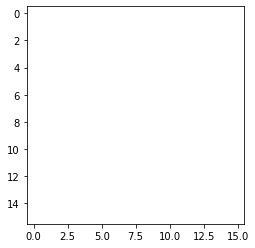

In [58]:
cropImg = image1[x_Upper_left:x_Lower_right, y_Upper_left:y_Lower_right]
plt.imshow(cropImg)#拼接显示为gray
plt.show()

In [59]:
source_landmark_read_result = pd.read_csv(source_image_landmarks[0])
target_landmark_read_result = pd.read_csv(target_image_landmarks[0])

In [60]:

img1 = cv2.imread(imgname1)
height1, width1, channels = img1.shape
img2 = cv2.imread(imgname2)
height2, width2, channels = img2.shape

source_cropImg_set = []
target_cropImg_set = []
for source_X, \
    source_Y ,\
    target_X,\
    target_Y in zip(source_landmark_read_result['X'],source_landmark_read_result['Y'],target_landmark_read_result['X'],target_landmark_read_result['Y']):
    
    source_x_Upper_left,source_y_Upper_left,source_x_Lower_right,source_y_Lower_right = get_neighbourhood (round(source_X),round(source_Y))
    target_x_Upper_left,target_y_Upper_left,target_x_Lower_right,target_y_Lower_right = get_neighbourhood (round(target_X),round(target_Y))
    
    source_cropImg = img1[source_y_Upper_left:source_y_Lower_right, source_x_Upper_left:source_x_Lower_right]
    target_cropImg = img2[target_y_Upper_left:target_y_Lower_right, target_x_Upper_left:target_x_Lower_right]
    
    # height, width, channels = source_cropImg.shape
    # print (source_x_Upper_left,source_x_Lower_right, source_y_Upper_left,source_y_Lower_right)
    print(source_cropImg.shape)
    source_cropImg_set.append(source_cropImg)
    target_cropImg_set.append(target_cropImg)
    ###### toDo use the two to make  CNN if they are the pairs


(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)
(16, 16, 3)


In [80]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,
                                          shuffle=True, num_workers=1)
target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,
                                          shuffle=True, num_workers=1)

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [82]:
net = matchNet()
labels = 1
net.to(device)

matchNet(
  (conv_0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_1): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool_4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (bottleNeck): Linear(in_features=128, out_features=512, bias=True)
  (fc_1): Linear(in_features=1024, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2)
)

In [83]:
net = nn.DataParallel(net, list(range(1)))

In [146]:
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for source,target in zip(source_trainloader, target_trainloader):
        # 置换 tensor from NWHC to NCWH
        b_size = 1
        label = torch.full((b_size,), labels,  device=device)
        
        
        source=source.permute(0, 3, 1, 2)
        target=target.permute(0, 3, 1, 2)
        source = source.float()
        target = target.float()
        outputs = net(source,target).view(-1)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()
        #################################
        # Here wantna to train the 
        ##################################
        j = 0
        for target_false in target_trainloader:
            # if the same one 
            if j == i :
                outputs = net(source,target).view(-1)
                loss = criterion(outputs, label)
                
            else:
                # not same
                labels_false = 0
                label_false = torch.full((b_size,), labels_false,  device=device)
                target_false=target_false.permute(0, 3, 1, 2)
                target_false = target_false.float()
                outputs = net(source,target_false).view(-1)
                loss = criterion(outputs, label_false)
                print(outputs)
                print(label_false)
                print(loss.item())
                
            loss.backward()
            optimizer.step()
            j = j+1
            
        
        
        i = i+1
        

tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0'

tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0'

tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0'

tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0'

tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0')
27.63102149963379
tensor([1.], device='cuda:0', grad_fn=<ViewBackward>)
tensor([0.], device='cuda:0'

KeyboardInterrupt: 

# the main train

The train is for training each pairs

In [144]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print ('begin training.........')

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    print ('epoch , ',epoch)
    
    num = 0
    for source,target, s_landmark,t_landmark in zip(source_image_array[:180], target_image_array[:180], source_image_landmarks[:180] ,target_image_landmarks[:180]):
        imgname1 = source
        imgname2 = target
        source_landmark_read_result = pd.read_csv(s_landmark)
        target_landmark_read_result = pd.read_csv(t_landmark)

        labels = 1
        
        num = num + 1


        # read the image and put the small regin in the train loader
        img1 = cv2.imread(imgname1)
        height1, width1, channels = img1.shape
        img2 = cv2.imread(imgname2)
        height2, width2, channels = img2.shape

        source_cropImg_set = []
        target_cropImg_set = []
        for source_X, \
            source_Y ,\
            target_X,\
            target_Y in zip(source_landmark_read_result['X'],source_landmark_read_result['Y'],target_landmark_read_result['X'],target_landmark_read_result['Y']):

            source_x_Upper_left,source_y_Upper_left,source_x_Lower_right,source_y_Lower_right = get_neighbourhood (round(source_X),round(source_Y))
            target_x_Upper_left,target_y_Upper_left,target_x_Lower_right,target_y_Lower_right = get_neighbourhood (round(target_X),round(target_Y))

            source_cropImg = img1[source_y_Upper_left:source_y_Lower_right, source_x_Upper_left:source_x_Lower_right]
            target_cropImg = img2[target_y_Upper_left:target_y_Lower_right, target_x_Upper_left:target_x_Lower_right]

            # height, width, channels = source_cropImg.shape
            # print (source_x_Upper_left,source_x_Lower_right, source_y_Upper_left,source_y_Lower_right)
            #
            source_cropImg_set.append(source_cropImg)
            target_cropImg_set.append(target_cropImg)
            ###### toDo use the two to make  CNN if they are the pairs
        ############# put the patch into the train loader
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        source_trainloader = torch.utils.data.DataLoader(source_cropImg_set, batch_size=1,shuffle=True, num_workers=1)
        target_trainloader = torch.utils.data.DataLoader(target_cropImg_set, batch_size=1,shuffle=True, num_workers=1)




        i = 0
        for source,target in zip(source_trainloader, target_trainloader):
            # 置换 tensor from NWHC to NCWH
            b_size = 1
            label = torch.full((b_size,), labels,  device=device)


            source=source.permute(0, 3, 1, 2)
            target=target.permute(0, 3, 1, 2)
            source = source.float()
            target = target.float()
            outputs = net(source,target)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            #################################
            # Here wantna to train the 
            ##################################
            j = 0
            for target_false in target_trainloader:
                # if the same one 
                if j == i :
                    outputs = net(source,target)
                    loss = criterion(outputs, label)
                    optimizer.step()
                else:
                    # not same
                    labels_false = 0
                    label_false = torch.full((b_size,), labels_false,  device=device)
                    target_false=target_false.permute(0, 3, 1, 2)
                    target_false = target_false.float()
                    outputs = net(source,target_false)
                    loss = criterion(outputs, label_false)

                loss.backward()
                optimizer.step()
                j = j+1


            
            print('The loss is',loss.item())
            i = i+1
        

begin training.........
epoch ,  0
The loss is 27.63102149963379
The loss is 27.63102149963379


KeyboardInterrupt: 

TypeError: 'int' object is not callable

In [114]:
num = 0
for source,target, s_landmark,t_landmark in zip(source_image_array[:300], target_image_array[:300],source_image_landmarks[:300] ,target_image_landmarks[:300]):
    print(s_landmark)
    num = num + 1

landmark/COAD_01/scale-25pc/S3.csv
landmark/COAD_01/scale-25pc/S6.csv
landmark/COAD_01/scale-25pc/S7.csv
landmark/COAD_01/scale-25pc/S6.csv
landmark/COAD_01/scale-25pc/S7.csv
landmark/COAD_01/scale-25pc/S7.csv
landmark/COAD_02/scale-25pc/S3.csv
landmark/COAD_02/scale-25pc/S6.csv
landmark/COAD_02/scale-25pc/S7.csv
landmark/COAD_02/scale-25pc/S6.csv
landmark/COAD_02/scale-25pc/S7.csv
landmark/COAD_02/scale-25pc/S7.csv
landmark/COAD_03/scale-25pc/S5.csv
landmark/COAD_04/scale-25pc/S5.csv
landmark/COAD_05/scale-25pc/S5-v1.csv
landmark/COAD_05/scale-25pc/S6.csv
landmark/COAD_05/scale-25pc/S7.csv
landmark/COAD_05/scale-25pc/S6.csv
landmark/COAD_05/scale-25pc/S7.csv
landmark/COAD_05/scale-25pc/S7.csv
landmark/COAD_06/scale-25pc/S5.csv
landmark/COAD_06/scale-25pc/S7.csv
landmark/COAD_06/scale-25pc/S7.csv
landmark/COAD_07/scale-25pc/S5.csv
landmark/COAD_07/scale-25pc/S7.csv
landmark/COAD_07/scale-25pc/S7.csv
landmark/COAD_08/scale-25pc/S3.csv
landmark/COAD_08/scale-25pc/S6.csv
landmark/COAD_08/

landmark/lung-lobes_4/scale-100pc/29-040-U-35W-Izd2-4-cc10.csv
landmark/lung-lobes_4/scale-100pc/29-040-U-35W-Izd2-6-ki67.csv
landmark/lung-lobes_4/scale-100pc/29-040-U-35W-Izd2-6-ki67.csv
landmark/mammary-gland_1/scale-25pc/s1_36-CNEU_A4926-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_37-HE_A4926-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_38-ER-A4962-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_40-PR_A4926-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_37-HE_A4926-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_38-ER-A4962-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_40-PR_A4926-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_38-ER-A4962-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_40-PR_A4926-4L.csv
landmark/mammary-gland_1/scale-25pc/s1_40-PR_A4926-4L.csv
landmark/mammary-gland_2/scale-25pc/s2_62-ER_A4926-4L.csv
landmark/mammary-gland_2/scale-25pc/s2_63-HE_A4926-4L.csv
landmark/mammary-gland_2/scale-25pc/s2_64-PR_A4926-4L.csv
landmark/mammary-gland_2/scale-25pc/s2_66-CNEU_A4926-4L

In [131]:
loss = 0.0
print('The loss is',loss)

The loss is 0.0


In [129]:
print (len(target_image_landmarks))

230
